In [29]:
import os
import json
import time
import requests
import rasterio
import zipfile
from pathlib import Path
from collections import defaultdict
from datetime import datetime, timezone, timedelta
from shapely.geometry import box, mapping
from rasterio.mask import mask
from pyproj import Transformer
from dotenv import load_dotenv
import numpy as np
from rasterio.warp import reproject, Resampling
from affine import Affine
import matplotlib.pyplot as plt

# Load token
load_dotenv()
token = os.getenv("EARTHDATA_BEARER")
if not token:
    raise RuntimeError("EARTHDATA_BEARER not set in .env file.")

# Paths
input_dir = Path("../data/processed/sentinel2")
output_dir = Path("../data/masks/dem_srtmgl1")
output_dir.mkdir(parents=True, exist_ok=True)

# SRTM base URL
SRTM_BASE_URL = "https://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/"
transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

# Group files by full patch_id from content (not just filename)
patch_groups = defaultdict(list)
for json_path in input_dir.glob("*.json"):
    with open(json_path) as f:
        meta = json.load(f)
        patch_id = meta["patch_id"]
        patch_groups[patch_id].append(json_path)

N = len(patch_groups)
start_time = time.time()

def download_srtm_tile(lat, lon, output_dir):
    tile_lat = f"{'N' if lat >= 0 else 'S'}{abs(int(np.floor(lat))):02d}"
    tile_lon = f"{'E' if lon >= 0 else 'W'}{abs(int(np.floor(lon))):03d}"
    tile_name = f"{tile_lat}{tile_lon}"
    zip_filename = f"{tile_name}.SRTMGL1.hgt.zip"
    tif_filename = f"{tile_name}.hgt"

    zip_url = f"{SRTM_BASE_URL}{zip_filename}"
    local_zip = output_dir / zip_filename
    local_tif = output_dir / tif_filename

    if local_tif.exists():
        return local_tif

    print(f"⬇️ Downloading {zip_filename}...")
    headers = {"Authorization": f"Bearer {token}"}
    r = requests.get(zip_url, stream=True, headers=headers)
    if r.status_code != 200:
        raise Exception(f"Download failed: {zip_url} (status {r.status_code})")

    with open(local_zip, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

    with zipfile.ZipFile(local_zip, "r") as z:
        z.extractall(output_dir)
    os.remove(local_zip)
    return local_tif

def save_metadata(patch_id, out_name, bounds):
    meta = {
        "patch_id": patch_id,
        "status": "success",
        "elevation_source": "SRTMGL1 (NASA Earthdata)",
        "elevation_resolution_m": 30,
        "bbox_wgs84": {
            "north": bounds[3], "south": bounds[2],
            "east": bounds[1], "west": bounds[0]
        },
        "query_date": datetime.now(timezone.utc).isoformat()
    }
    with open(output_dir / f"{out_name}.json", "w") as f:
        json.dump(meta, f, indent=2)

# Process each full patch_id
for idx, (patch_id, files) in enumerate(patch_groups.items(), 1):
    print(f"\n[{idx}/{N}] Processing patch group: {patch_id}")
    first_json = files[0]
    with open(first_json) as f:
        meta = json.load(f)

    # Get bounding box
    uly, ulx = meta["bbox"]["upper_left"]
    lry, lrx = meta["bbox"]["bottom_right"]
    west, north = transformer.transform(ulx, uly)
    east, south = transformer.transform(lrx, lry)
    if west > east: west, east = east, west
    if south > north: south, north = north, south
    bounds = (west, east, south, north)

    out_name = f"dem_{patch_id}"
    out_tif = output_dir / f"{out_name}.tiff"
    out_preview = output_dir / f"preview_{out_name}.png"
    out_json = output_dir / f"{out_name}.json"

    # Skip if already processed
    if out_tif.exists() and out_json.exists() and out_preview.exists():
        print(f"[{idx}/{N}] ✅ Skipping (already exists): {patch_id}")
        continue

    try:
        # Download SRTM tile
        lat_center = (south + north) / 2
        lon_center = (west + east) / 2
        tile_path = download_srtm_tile(lat_center, lon_center, output_dir)

        # Mask and reproject DEM
        with rasterio.open(tile_path) as src:
            ref_crs = "EPSG:3857"
            height = width = 1024
            xres = (lrx - ulx) / width
            yres = (uly - lry) / height
            ref_transform = Affine.translation(ulx, uly) * Affine.scale(xres, -yres)

            dst_array = np.empty((1, height, width), dtype="int16")

            reproject(
                source=rasterio.band(src, 1),
                destination=dst_array,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref_transform,
                dst_crs=ref_crs,
                resampling=Resampling.bilinear,
                dst_nodata=-32768
            )

            profile = src.profile.copy()
            profile.update({
                "driver": "GTiff",
                "dtype": "int16",
                "count": 1,
                "crs": ref_crs,
                "transform": ref_transform,
                "height": height,
                "width": width,
                "nodata": -32768
            })

            # Save GeoTIFF
            with rasterio.open(out_tif, "w", **profile) as dst:
                dst.write(dst_array.astype("int16"))
            save_metadata(patch_id, out_name, bounds)
            print(f"   🗺️ Saved: {out_tif.name}")

            # Save preview
            plt.figure(figsize=(5, 5))
            plt.imshow(dst_array[0], cmap="terrain")
            plt.colorbar(label="Elevation (m)")
            plt.title(f"DEM Patch {patch_id}")
            plt.axis("off")
            plt.tight_layout()
            plt.savefig(out_preview)
            plt.close()
            print(f"   🖼️ Preview saved: {out_preview.name}")

    except Exception as e:
        print(f"❌ Error for patch {patch_id}: {e}")

    # ETA log
    elapsed = time.time() - start_time
    avg_time = elapsed / idx
    eta = avg_time * (N - idx)
    print(f"   ⏱ {1/avg_time:.2f} patches/sec | ETA: {str(timedelta(seconds=int(eta)))}")
    time.sleep(1)



[1/16] Processing patch group: patch_00042_e6bff2f8
⬇️ Downloading S09E115.SRTMGL1.hgt.zip...
   🗺️ Saved: dem_patch_00042_e6bff2f8.tiff
   🖼️ Preview saved: preview_dem_patch_00042_e6bff2f8.png
   ⏱ 0.16 patches/sec | ETA: 0:01:31

[2/16] Processing patch group: patch_00044_4359be37
   🗺️ Saved: dem_patch_00044_4359be37.tiff
   🖼️ Preview saved: preview_dem_patch_00044_4359be37.png
   ⏱ 0.27 patches/sec | ETA: 0:00:51

[3/16] Processing patch group: patch_00052_4b0beee9
   🗺️ Saved: dem_patch_00052_4b0beee9.tiff
   🖼️ Preview saved: preview_dem_patch_00052_4b0beee9.png
   ⏱ 0.35 patches/sec | ETA: 0:00:37

[4/16] Processing patch group: patch_00035_2dffd3d8
   🗺️ Saved: dem_patch_00035_2dffd3d8.tiff
   🖼️ Preview saved: preview_dem_patch_00035_2dffd3d8.png
   ⏱ 0.40 patches/sec | ETA: 0:00:29

[5/16] Processing patch group: patch_00058_4d51287e
   🗺️ Saved: dem_patch_00058_4d51287e.tiff
   🖼️ Preview saved: preview_dem_patch_00058_4d51287e.png
   ⏱ 0.45 patches/sec | ETA: 0:00:24

[6

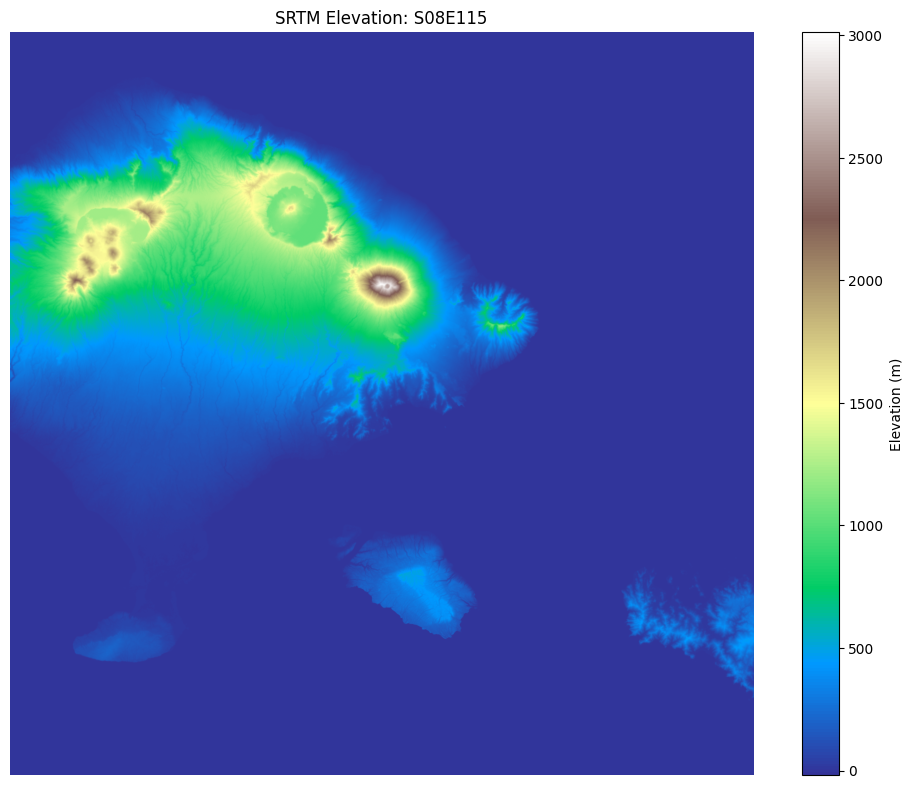

In [30]:
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path

# Path to the .hgt file
hgt_path = Path("../data/masks/dem_srtmgl1/S09E115.hgt")

# Open and read the elevation data
with rasterio.open(hgt_path) as src:
    elevation = src.read(1)
    nodata = src.nodata if src.nodata is not None else -32768
    elevation = elevation.astype("float32")
    elevation[elevation == nodata] = float('nan')  # Mask nodata for display

# Plot the elevation
plt.figure(figsize=(10, 8))
plt.imshow(elevation, cmap='terrain')
plt.title("SRTM Elevation: S08E115")
plt.colorbar(label="Elevation (m)")
plt.axis('off')
plt.tight_layout()
plt.show()

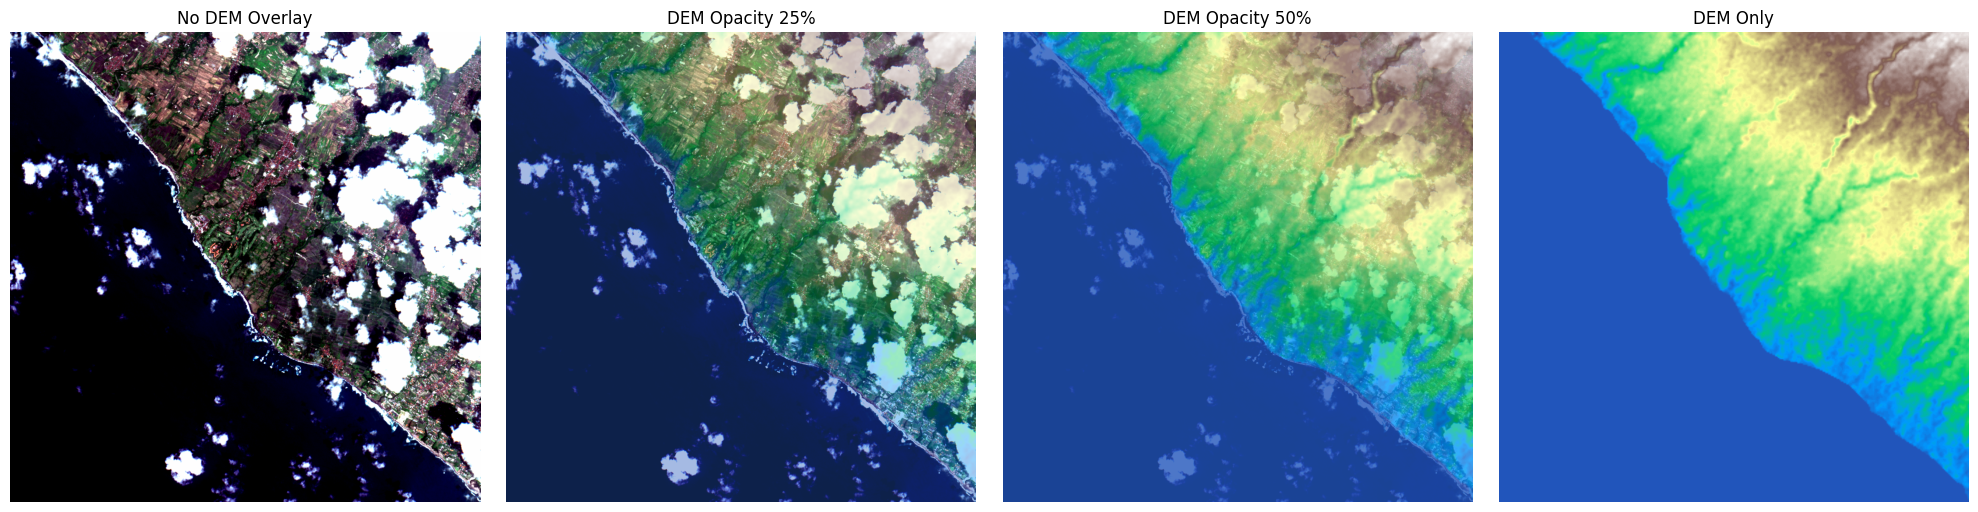

In [31]:
import tifffile as tiff
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# File paths
s2_path = Path("../data/processed/sentinel2/patch_00032_5925311e_20151230T024015.355000+0000_res1024.tiff")
dem_path = Path("../data/masks/dem_srtmgl1/dem_patch_00032_5925311e.tiff")

# Load Sentinel-2 with tifffile (shape: H, W, 13)
s2_cube = tiff.imread(s2_path)  # shape: (13, 1024, 1024)
s2_cube = s2_cube.transpose(1, 2, 0)  # to (1024, 1024, 13)

# Extract RGB bands — Sentinel-2: B04=3, B03=2, B02=1
red   = s2_cube[:, :, 3].astype(np.float32)
green = s2_cube[:, :, 2].astype(np.float32)
blue  = s2_cube[:, :, 1].astype(np.float32)

# Normalize each band for display
def normalize(b):
    return (b - np.nanmin(b)) / (np.nanmax(b) - np.nanmin(b) + 1e-6)

rgb = np.stack([normalize(red), normalize(green), normalize(blue)], axis=-1)

# Load and normalize DEM
with rasterio.open(dem_path) as dem_src:
    dem = dem_src.read(1).astype("float32")
    dem[dem == -32768] = np.nan
    dem_norm = normalize(dem)

# Opacity levels
opacities = [0.0, 0.4, 0.8, 1.0]
titles = ["No DEM Overlay", "DEM Opacity 25%", "DEM Opacity 50%", "DEM Only"]

# Plot 4 subplots with varying DEM transparency
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for ax, alpha, title in zip(axes, opacities, titles):
    ax.imshow(rgb)
    ax.imshow(dem_norm, cmap="terrain", alpha=alpha)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [32]:
import numpy as np
import rasterio
from rasterio import Affine
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import ndimage

# Paths
dem_dir = Path("../data/masks/dem_srtmgl1")
dem_files = sorted(dem_dir.glob("dem_patch_*.tiff"))

# Output files
slope_prefix = "dem_slope_patch_"
preview_prefix = "preview_dem_slope_patch_"

# Slope calculation
def compute_slope(dem_array, transform):
    xres = transform.a  # pixel width
    yres = -transform.e  # pixel height (negative for south-up)

    # Sobel filters for horizontal and vertical gradients
    dzdx = ndimage.sobel(dem_array, axis=1, mode='nearest') / (8.0 * xres)
    dzdy = ndimage.sobel(dem_array, axis=0, mode='nearest') / (8.0 * yres)

    slope_rad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))
    slope_deg = np.degrees(slope_rad)
    return slope_deg.astype("float32")

# Process each DEM
for dem_path in dem_files:
    patch_id = dem_path.stem.replace("dem_patch_", "")
    out_tif = dem_dir / f"{slope_prefix}{patch_id}.tiff"
    out_png = dem_dir / f"{preview_prefix}{patch_id}.png"

    # Skip if already done
    if out_tif.exists() and out_png.exists():
        print(f"✅ Skipping {patch_id} (already exists)")
        continue

    with rasterio.open(dem_path) as src:
        dem = src.read(1).astype("float32")
        dem[dem == -32768] = np.nan
        slope = compute_slope(dem, src.transform)

        # Save slope GeoTIFF
        profile = src.profile.copy()
        profile.update({
            "dtype": "float32",
            "count": 1,
            "nodata": np.nan
        })

        with rasterio.open(out_tif, "w", **profile) as dst:
            dst.write(slope, 1)
        print(f"🗺️ Slope map saved: {out_tif.name}")

        # Save preview image
        plt.figure(figsize=(5, 5))
        plt.imshow(slope, cmap="viridis")
        plt.colorbar(label="Slope (°)")
        plt.title(f"Slope Patch {patch_id}")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(out_png)
        plt.close()
        print(f"🖼️ Preview saved: {out_png.name}")


🗺️ Slope map saved: dem_slope_patch_00032_5925311e.tiff
🖼️ Preview saved: preview_dem_slope_patch_00032_5925311e.png
🗺️ Slope map saved: dem_slope_patch_00033_4e36ed13.tiff
🖼️ Preview saved: preview_dem_slope_patch_00033_4e36ed13.png
🗺️ Slope map saved: dem_slope_patch_00034_1558c231.tiff
🖼️ Preview saved: preview_dem_slope_patch_00034_1558c231.png
🗺️ Slope map saved: dem_slope_patch_00035_2dffd3d8.tiff
🖼️ Preview saved: preview_dem_slope_patch_00035_2dffd3d8.png
🗺️ Slope map saved: dem_slope_patch_00041_6f274c8a.tiff
🖼️ Preview saved: preview_dem_slope_patch_00041_6f274c8a.png
🗺️ Slope map saved: dem_slope_patch_00042_e6bff2f8.tiff
🖼️ Preview saved: preview_dem_slope_patch_00042_e6bff2f8.png
🗺️ Slope map saved: dem_slope_patch_00043_691c8352.tiff
🖼️ Preview saved: preview_dem_slope_patch_00043_691c8352.png
🗺️ Slope map saved: dem_slope_patch_00044_4359be37.tiff
🖼️ Preview saved: preview_dem_slope_patch_00044_4359be37.png
🗺️ Slope map saved: dem_slope_patch_00050_b75fc6d6.tiff
🖼️ Previ

/tmp/ipykernel_79328/3230012421.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


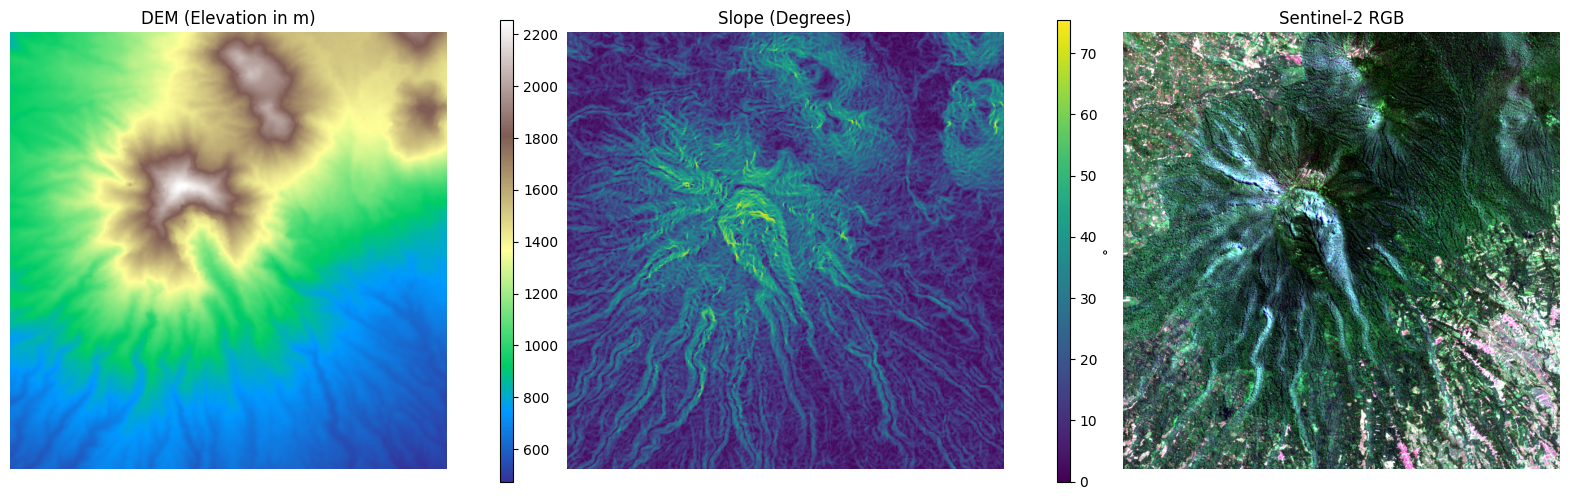

In [36]:
import tifffile as tiff
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from matplotlib import gridspec

# File paths (DEM and slope are fixed)
patch_id = "00035_2dffd3d8"
s2_dir = Path("../data/processed/sentinel2")
dem_path = Path(f"../data/masks/dem_srtmgl1/dem_patch_{patch_id}.tiff")
slope_path = Path(f"../data/masks/dem_srtmgl1/dem_slope_patch_{patch_id}.tiff")

# # Randomly select one Sentinel-2 TIFF for this patch
# s2_candidates = list(s2_dir.glob(f"patch_{patch_id}_*.tiff"))
# if not s2_candidates:
#     raise FileNotFoundError(f"No Sentinel-2 TIFFs found for patch ID {patch_id}")
# s2_path = random.choice(s2_candidates)
# print(f"🛰️ Using Sentinel-2 file: {s2_path.name}")
s2_path = "../data/processed/sentinel2/patch_00035_2dffd3d8_20170915T024005.763000+0000_res1024.tiff"

# Load Sentinel-2 (tifffile, HWC format)
s2_cube = tiff.imread(s2_path).transpose(1, 2, 0)
red, green, blue = [s2_cube[:, :, i].astype(np.float32) for i in [3, 2, 1]]
normalize = lambda b: (b - np.nanmin(b)) / (np.nanmax(b) - np.nanmin(b) + 1e-6)
rgb = np.stack([normalize(red), normalize(green), normalize(blue)], axis=-1)
h, w, _ = rgb.shape

# Load and align DEM
with rasterio.open(dem_path) as src:
    dem = src.read(1).astype("float32")
    dem[dem == -32768] = np.nan
    dem = dem[:h, :w]

# Load and align slope
with rasterio.open(slope_path) as src:
    slope = src.read(1).astype("float32")
    slope[slope == src.nodata] = np.nan
    slope = slope[:h, :w]

# Grid layout: 3 images + 2 colorbars
fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 5, width_ratios=[1, 0.03, 1, 0.03, 1], wspace=0.2)

# Sentinel-2
ax0 = fig.add_subplot(gs[4])
ax0.imshow(rgb)
ax0.set_title("Sentinel-2 RGB")
ax0.axis("off")

# DEM
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(dem, cmap="terrain")
ax1.set_title("DEM (Elevation in m)")
ax1.axis("off")
cax1 = fig.add_subplot(gs[1])
fig.colorbar(im1, cax=cax1, label="m")

# Slope
ax2 = fig.add_subplot(gs[2])
im2 = ax2.imshow(slope, cmap="viridis")
ax2.set_title("Slope (Degrees)")
ax2.axis("off")
cax2 = fig.add_subplot(gs[3])
fig.colorbar(im2, cax=cax2, label="°")

plt.tight_layout()
plt.show()
